In [46]:
# Standard module imports
import numpy as np
import scipy.stats as stats
import pandas as pd
import sys
%matplotlib inline

# Useful directories
gh_dir = '/Users/ttshimiz/Github/'
sed_fit_dir = gh_dir + 'bat-agn-sed-fitting/'
casey_dir = sed_fit_dir + 'analysis/casey_bayes_results/'
data_dir = gh_dir + 'bat-data/'

sys.path.append(gh_dir+'asurv/')

import asurv

In [47]:
# Setup the figures
execfile('../code/figure-setup.py')

##Get all of the data for the BAT AGN

In [61]:
# Upload the fitting results for the C12 model
bat_casey = pd.read_csv('/Users/ttshimiz/Github/bat-agn-sed-fitting/'+
                        'analysis/casey_bayes_results/beta_fixed_2_wturn_gaussianPrior/'+
                        'final_fit_results_beta_fixed_2_wturn_gaussianPrior_v3.csv', index_col=0)
bat_casey_undetected = pd.read_csv(casey_dir+'beta_fixed_2_wturn_gaussianPrior/'+
                                   'final_fit_results_beta_fixed_2_wturn_gaussianPrior_undetected.csv', index_col=0)
# Remove 'bad' sources
bad_sources = np.array(['PICTORA', '3C111.0', '3C120',
                        '2MASXJ23272195+1524375', 'PKS2331-240',
                        'HB890241+622', 'Mrk3'])
bat_casey = bat_casey.drop(bad_sources)
bat_casey_undetected.loc['UGC06728', 'lir_bb'] += 2.0
bat_casey_undetected.loc['UGC06728', 'mdust'] += 2.0

# Upload the info for the BAT AGN (i.e. AGN type, luminosity distance, redshift, etc)
bat_info = pd.read_csv(data_dir+'bat_info.csv', index_col=0)
#bat_info.loc['UGC06728', 'Dist_[Mpc]'] = 292.0

# We need to calculate stellar masses for the BAT AGN using the method in Zibetti et al 2009 since this method was used
# for both the KINGFISH and HRS galaxies. I use the AGN subtracted SDSS photometry from Koss et al 2011 and the g-i color
# relation for the stellar masses.
bat_koss = pd.read_csv(data_dir+'bat_koss11.csv', index_col=0)
bat_koss.loc[bat_koss['griz_cont']=='Y', 'SDSS_i_Koss'] = np.nan
bi = 1.8e-10
bat_koss['SDSS_i_flux'] = 3631.*(2*bi*np.sinh(-np.log(10)*bat_koss['SDSS_i_Koss']/2.5 - np.log(bi)))
bat_koss['SDSS_Li'] = 4*np.pi*(bat_info['Dist_[Mpc]']*10**6*3.09e18)**2*(3.0e10/0.7480e-4)*bat_koss['SDSS_i_flux']*10**(-23)
bat_casey['Mstar'] = (-0.963 + 1.032*(bat_koss['SDSS_g_Koss'] - bat_koss['SDSS_i_Koss']) +
                     np.log10(bat_koss['SDSS_Li']/3.846e33))
bat_casey_undetected['Mstar'] = (-0.963 + 1.032*(bat_koss['SDSS_g_Koss'] - bat_koss['SDSS_i_Koss']) +
                                np.log10(bat_koss['SDSS_Li']/3.846e33))

##Get all of the data for the HRS sample

In [49]:
# Upload the HRS fits
hrs_casey = pd.read_csv(casey_dir+'hrs_beta_fixed_2_wturn_gaussianPrior/final_fit_results_beta_fixed_2_wturn_gaussianPrior_hrs.csv', index_col=0)
hrs_casey_undetected = pd.read_csv(casey_dir+'hrs_beta_fixed_2_wturn_gaussianPrior/final_fit_results_beta_fixed_2_wturn_gaussianPrior_undetected_hrs.csv', index_col=0)

# Upload the HRS info
hrs_info = pd.read_table(gh_dir+'hrs-data/hrs_photometry.txt', delimiter='\t', index_col=0, na_values=-99.99)

# HRS gas-rich galaxies
hrs_gas_rich = np.array([np.loadtxt(gh_dir+'hrs-data/hrs_gas_rich_numbers.txt')], dtype = int)[0]

hrs_casey['Mstar'] = hrs_info['logMstart']
hrs_casey_undetected['Mstar'] = hrs_info['logMstart']

##Get all of the data for the KINGFISH galaxies

In [50]:
# Upload the KINGFISH fits
kf_casey = pd.read_csv(casey_dir+'kingfish_beta_fixed_2_wturn_gaussianPrior/final_fit_results_kingfish_casey.csv',
                       index_col=0)
kf_casey_undetected = pd.read_csv(casey_dir+'kingfish_beta_fixed_2_wturn_gaussianPrior/final_fit_results_beta_fixed_2_wturn_gaussianPrior_undetected_kingfish.csv', index_col=0)

# Upload the KINGFISH info
kf_info = pd.read_table('/Users/ttshimiz/Dropbox/Research/Thesis/Other_surveys/KINGFISH/kingfish_data.txt',
                        index_col=0, delimiter='\t')

# Identify the dwarf galaxies as any galaxy with stellar mass < 10^8 Msun
kf_dwarfs = kf_info['Mstar'] < 8.0

kf_casey['Mstar'] = kf_info['Mstar']
kf_casey_undetected['Mstar'] = kf_info['Mstar']

In [62]:
# Calculate SFR for all three samples
bat_casey['SFR'] = bat_casey['lir_bb'] + np.log10(4./3.) + np.log10(3.846e33) - np.log10(2.57e43)
bat_casey_undetected['SFR'] = bat_casey_undetected['lir_bb'] + np.log10(4./3.) + np.log10(3.846e33) - np.log10(2.57e43)
hrs_casey['SFR'] = hrs_casey['lir_total'] + np.log10(3.846e33) - np.log10(2.57e43)
hrs_casey_undetected['SFR'] = hrs_casey_undetected['lir_total'] + np.log10(3.846e33) - np.log10(2.57e43)
kf_casey['SFR'] = kf_casey['lir_total'] + np.log10(3.846e33) - np.log10(2.57e43) 
kf_casey_undetected['SFR'] = kf_casey_undetected['lir_total'] + np.log10(3.846e33) - np.log10(2.57e43)

## Dust Mass, Dust Temperature, and SFR Comparison

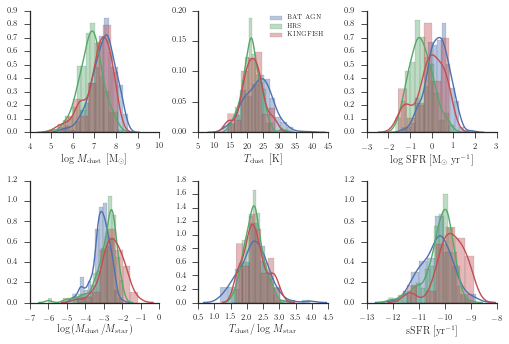

In [7]:
fig = plt.figure(figsize=(1.2*textwidth, 1./2.*1.5*textwidth))
ax1 = fig.add_subplot(231)
sn.distplot(bat_casey['mdust'].dropna(), label='BAT AGN', color='b', ax=ax1)
sn.distplot(hrs_casey['mdust'].dropna(), label='HRS', color='g', ax=ax1)
sn.distplot(kf_casey['mdust'][~kf_dwarfs].dropna(), label='KINGFISH', color='r', ax=ax1)
plt.xlabel(r'$\log\,M_{\rm dust}$ [M$_{\odot}$]')
sn.despine()

ax2 = fig.add_subplot(232)
sn.distplot(bat_casey['tdust'].dropna(), label='BAT AGN', color='b', ax=ax2)
sn.distplot(hrs_casey['tdust'].dropna(), label='HRS', color='g', ax=ax2)
sn.distplot(kf_casey['tdust'][~kf_dwarfs].dropna(), label='KINGFISH', color='r', ax=ax2)
plt.xlabel(r'$T_{\rm dust}$ [K]')
plt.legend(loc='upper right', fontsize=6)
sn.despine()

ax3 = fig.add_subplot(233)
sn.distplot(bat_casey['SFR'].dropna(), label='BAT AGN', color='b', ax=ax3)
sn.distplot(hrs_casey['SFR'].dropna(), label='HRS', color='g', ax=ax3)
sn.distplot(kf_casey['SFR'][~kf_dwarfs].dropna(), label='KINGFISH', color='r', ax=ax3)
plt.xlabel(r'$\log$ SFR [M$_{\odot}$ yr$^{-1}$]')
sn.despine()

ax4 = fig.add_subplot(234)
sn.distplot((bat_casey['mdust'] - bat_casey['Mstar']).dropna(), label='BAT AGN', color='b', ax=ax4)
sn.distplot((hrs_casey['mdust'] - hrs_casey['Mstar']).dropna(), label='HRS', color='g', ax=ax4)
sn.distplot((kf_casey['mdust'][~kf_dwarfs] - kf_casey['Mstar'][~kf_dwarfs]).dropna(), label='KINGFISH', color='r', ax=ax4)
plt.xlabel(r'$\log\,(M_{\rm dust}/M_{\rm star})$')
sn.despine()


ax5 = fig.add_subplot(235)
sn.distplot((bat_casey['tdust']/bat_casey['Mstar']).dropna(), label='BAT AGN', color='b', ax=ax5)
sn.distplot((hrs_casey['tdust']/hrs_casey['Mstar']).dropna(), label='HRS', color='g', ax=ax5)
sn.distplot((kf_casey['tdust'][~kf_dwarfs]/kf_casey['Mstar'][~kf_dwarfs]).dropna(), label='KINGFISH', color='r', ax=ax5)
plt.xlabel(r'$T_{\rm dust}/\log\,M_{\rm star}$')
sn.despine()

ax6 = fig.add_subplot(236)
sn.distplot((bat_casey['SFR'] - bat_casey['Mstar']).dropna(), label='BAT AGN', color='b', ax=ax6)
sn.distplot((hrs_casey['SFR'] - hrs_casey['Mstar']).dropna(), label='HRS', color='g', ax=ax6)
sn.distplot((kf_casey['SFR'][~kf_dwarfs] - kf_casey['Mstar'][~kf_dwarfs]).dropna(), label='KINGFISH', color='r', ax=ax6)
plt.xlabel(r'sSFR [yr$^{-1}$]')
sn.despine()

fig.subplots_adjust(wspace=0.3, hspace=0.4)

#fig.savefig('../figures/mdust_tdust_sfr_comparison.pdf', bbox_inches='tight')

##Analysis of the distributions for each sample

Calculation of the median and spread for each sample in Mdust, Tdust, and SFR. Also normalize the values with stellar mass. Use survival tests to determine whether they come from same parent distribution. For now use only the detected objects. This shouldn't be too bad since the BAT AGN only have 35 that aren't detected, HRS has 27, and KINGFISH has 2.

In [8]:
bat_agn_mdust_med = np.mean(bat_casey['mdust'])
hrs_mdust_med = np.mean(hrs_casey['mdust'])
kf_mdust_med = np.mean(kf_casey[~kf_dwarfs]['mdust'])

bat_agn_mdust_std = np.std(bat_casey['mdust'])
hrs_mdust_std = np.std(hrs_casey['mdust'])
kf_mdust_std = np.std(kf_casey[~kf_dwarfs]['mdust'])

print 'Mean log(Dust Masses):'
print 'BAT AGN: ', bat_agn_mdust_med, '+/-', bat_agn_mdust_std
print 'HRS: ', hrs_mdust_med, '+/-', hrs_mdust_std
print 'KINGFISH: ', kf_mdust_med, '+/-', kf_mdust_std

Mean log(Dust Masses):
BAT AGN:  7.40285685905 +/- 0.565433279745
HRS:  6.83896323882 +/- 0.553285325195
KINGFISH:  7.17136697542 +/- 0.626154205624


/Users/ttshimiz/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


In [9]:
bat_agn_tdust_med = np.mean(bat_casey['tdust'])
hrs_tdust_med = np.mean(hrs_casey['tdust'])
kf_tdust_med = np.mean(kf_casey[~kf_dwarfs]['tdust'])

bat_agn_tdust_std = np.std(bat_casey['tdust'])
hrs_tdust_std = np.std(hrs_casey['tdust'])
kf_tdust_std = np.std(kf_casey[~kf_dwarfs]['tdust'])

print 'Mean Dust Temperatures:'
print 'BAT AGN: ', bat_agn_tdust_med, '+/-', bat_agn_tdust_std/np.sqrt(len(bat_casey['tdust']))
print 'HRS: ', hrs_tdust_med, '+/-', hrs_tdust_std/np.sqrt(len(hrs_casey['tdust']))
print 'KINGFISH: ', kf_tdust_med, '+/-', kf_tdust_std/np.sqrt(len(kf_casey['tdust']))

Mean Dust Temperatures:
BAT AGN:  23.4619137604 +/- 0.265984093875
HRS:  21.4728018107 +/- 0.178662897431
KINGFISH:  21.7219940791 +/- 0.455115806399


In [10]:
bat_agn_sfr_med = np.mean(bat_casey['SFR'])
hrs_sfr_med = np.mean(hrs_casey['SFR'])
kf_sfr_med = np.mean(kf_casey[~kf_dwarfs]['SFR'])

bat_agn_sfr_std = np.std(bat_casey['SFR'])
hrs_sfr_std = np.std(hrs_casey['SFR'])
kf_sfr_std = np.std(kf_casey[~kf_dwarfs]['SFR'])

print 'Mean log(SFR):'
print 'BAT AGN: ', bat_agn_sfr_med, '+/-', bat_agn_sfr_std
print 'HRS: ', hrs_sfr_med, '+/-', hrs_sfr_std
print 'KINGFISH: ', kf_sfr_med, '+/-', kf_sfr_std

Mean log(SFR):
BAT AGN:  0.276550617918 +/- 0.535737004166
HRS:  -0.486032265018 +/- 0.535407202543
KINGFISH:  -0.0864578479325 +/- 0.650853365412


In [11]:
bat_agn_mdust_mstar_med = np.mean(bat_casey['mdust'] - bat_casey['Mstar'])
hrs_mdust_mstar_med = np.mean(hrs_casey['mdust'] - hrs_casey['Mstar'])
kf_mdust_mstar_med = np.mean(kf_casey[~kf_dwarfs]['mdust'] - kf_casey[~kf_dwarfs]['Mstar'])

bat_agn_mdust_mstar_std = np.std(bat_casey['mdust'] - bat_casey['Mstar'])
hrs_mdust_mstar_std = np.std(hrs_casey['mdust'] - hrs_casey['Mstar'])
kf_mdust_mstar_std = np.std(kf_casey[~kf_dwarfs]['mdust'] - kf_casey[~kf_dwarfs]['Mstar'])

print 'Mean log(Dust Mass/ Stellar Mass):'
print 'BAT AGN: ', bat_agn_mdust_mstar_med, '+/-', bat_agn_mdust_mstar_std
print 'HRS: ', hrs_mdust_mstar_med, '+/-', hrs_mdust_mstar_std
print 'KINGFISH: ', kf_mdust_mstar_med, '+/-', kf_mdust_mstar_std

Mean log(Dust Mass/ Stellar Mass):
BAT AGN:  -3.15286626315 +/- 0.504340527324
HRS:  -2.88249830488 +/- 0.654794538559
KINGFISH:  -2.52182451395 +/- 0.609172053994


In [12]:
bat_agn_tdust_mstar_med = np.mean(bat_casey['tdust']/bat_casey['Mstar'])
hrs_tdust_mstar_med = np.mean(hrs_casey['tdust']/hrs_casey['Mstar'])
kf_tdust_mstar_med = np.mean(kf_casey[~kf_dwarfs]['tdust']/kf_casey[~kf_dwarfs]['Mstar'])

bat_agn_tdust_mstar_std = np.std(bat_casey['tdust']/bat_casey['Mstar'])
hrs_tdust_mstar_std = np.std(hrs_casey['tdust']/hrs_casey['Mstar'])
kf_tdust_mstar_std = np.std(kf_casey[~kf_dwarfs]['tdust']/kf_casey[~kf_dwarfs]['Mstar'])

print 'Mean Dust Temperature/log(Stellar Mass):'
print 'BAT AGN: ', bat_agn_tdust_mstar_med, '+/-', bat_agn_tdust_mstar_std/np.sqrt(len(bat_casey['tdust']))
print 'HRS: ', hrs_tdust_mstar_med, '+/-', hrs_tdust_mstar_std/np.sqrt(len(hrs_casey['tdust']))
print 'KINGFISH: ', kf_tdust_mstar_med, '+/-', kf_tdust_mstar_std/np.sqrt(len(kf_casey['tdust']))

Mean Dust Temperature/log(Stellar Mass):
BAT AGN:  2.20901846769 +/- 0.0275227576316
HRS:  2.21439341459 +/- 0.0182260295326
KINGFISH:  2.24848867474 +/- 0.0488317026557


In [13]:
bat_agn_sfr_mstar_med = np.mean(bat_casey['SFR'] - bat_casey['Mstar'])
hrs_sfr_mstar_med = np.mean(hrs_casey['SFR'] - hrs_casey['Mstar'])
kf_sfr_mstar_med = np.mean(kf_casey[~kf_dwarfs]['SFR'] - kf_casey[~kf_dwarfs]['Mstar'])

bat_agn_sfr_mstar_std = np.std(bat_casey['SFR'] - bat_casey['Mstar'])
hrs_sfr_mstar_std = np.std(hrs_casey['SFR'] - hrs_casey['Mstar'])
kf_sfr_mstar_std = np.std(kf_casey[~kf_dwarfs]['SFR'] - kf_casey[~kf_dwarfs]['Mstar'])

print 'Mean log(Dust Mass/ Stellar Mass):'
print 'BAT AGN: ', bat_agn_sfr_mstar_med, '+/-', bat_agn_sfr_mstar_std
print 'HRS: ', hrs_sfr_mstar_med, '+/-', hrs_sfr_mstar_std
print 'KINGFISH: ', kf_sfr_mstar_med, '+/-', kf_sfr_mstar_std

Mean log(Dust Mass/ Stellar Mass):
BAT AGN:  -10.3012250039 +/- 0.595312150249
HRS:  -10.2077445566 +/- 0.5419628716
KINGFISH:  -9.77964933729 +/- 0.58217430278


##Analysis with Undetected Sources

In [63]:
bat_mdust_km = asurv.KaplanMeierDist(np.hstack([bat_casey['mdust'].values, bat_casey_undetected['mdust'].values]),
                                     cens=np.hstack([np.ones(len(bat_casey)), np.zeros(len(bat_casey_undetected))]))
hrs_mdust_km = asurv.KaplanMeierDist(np.hstack([hrs_casey['mdust'].values, hrs_casey_undetected['mdust'].values]),
                                     cens=np.hstack([np.ones(len(hrs_casey)), np.zeros(len(hrs_casey_undetected))]))
kf_mdust_km = asurv.KaplanMeierDist(np.hstack([kf_casey['mdust'].values, kf_casey_undetected['mdust'].values]),
                                     cens=np.hstack([np.ones(len(kf_casey)), np.zeros(len(kf_casey_undetected))]))
bat_mdust_km_mean = bat_mdust_km.km_mean()
hrs_mdust_km_mean = hrs_mdust_km.km_mean()
kf_mdust_km_mean = kf_mdust_km.km_mean()

print 'Mean log(Dust Mass) with upper limits:'
print 'BAT: ', bat_mdust_km_mean[0], '+/-', bat_mdust_km_mean[1]
print 'HRS: ', hrs_mdust_km_mean[0], '+/-', hrs_mdust_km_mean[1]
print 'KINGFISH: ', kf_mdust_km_mean[0], '+/-', kf_mdust_km_mean[1]

Mean log(Dust Mass) with upper limits:
BAT:  7.21987899873 +/- 0.0441466659524
HRS:  6.7014978902 +/- 0.0435300054697
KINGFISH:  6.83818832847 +/- 0.144675447478


In [64]:
bat_sfr_km = asurv.KaplanMeierDist(np.hstack([bat_casey['SFR'].values, bat_casey_undetected['SFR'].values]),
                                     cens=np.hstack([np.ones(len(bat_casey)), np.zeros(len(bat_casey_undetected))]))
hrs_sfr_km = asurv.KaplanMeierDist(np.hstack([hrs_casey['SFR'].values, hrs_casey_undetected['SFR'].values]),
                                     cens=np.hstack([np.ones(len(hrs_casey)), np.zeros(len(hrs_casey_undetected))]))
kf_sfr_km = asurv.KaplanMeierDist(np.hstack([kf_casey['SFR'].values, kf_casey_undetected['SFR'].values]),
                                     cens=np.hstack([np.ones(len(kf_casey)), np.zeros(len(kf_casey_undetected))]))
bat_sfr_km_mean = bat_sfr_km.km_mean()
hrs_sfr_km_mean = hrs_sfr_km.km_mean()
kf_sfr_km_mean = kf_sfr_km.km_mean()

print 'Mean log(SFR) with upper limits:'
print 'BAT: ', bat_sfr_km_mean[0], '+/-', bat_sfr_km_mean[1]
print 'HRS: ', hrs_sfr_km_mean[0], '+/-', hrs_sfr_km_mean[1]
print 'KINGFISH: ', kf_sfr_km_mean[0], '+/-', kf_sfr_km_mean[1]

Mean log(SFR) with upper limits:
BAT:  -0.155327541408 +/- 0.0762116931419
HRS:  -0.582194471009 +/- 0.0371437703698
KINGFISH:  -0.389768475104 +/- 0.140298768653


In [65]:
reload(asurv)
bat_mdust_mstar_km = asurv.KaplanMeierDist(np.hstack([(bat_casey['mdust']-bat_casey['Mstar']).values,
                                                      (bat_casey_undetected['mdust']-bat_casey_undetected['Mstar']).values]),
                                           cens=np.hstack([np.ones(len(bat_casey)), np.zeros(len(bat_casey_undetected))]))
hrs_mdust_mstar_km = asurv.KaplanMeierDist(np.hstack([(hrs_casey['mdust']-hrs_casey['Mstar']).values,
                                                      (hrs_casey_undetected['mdust']-hrs_casey_undetected['Mstar']).values]),
                                           cens=np.hstack([np.ones(len(hrs_casey)), np.zeros(len(hrs_casey_undetected))]))
kf_mdust_mstar_km = asurv.KaplanMeierDist(np.hstack([(kf_casey['mdust']-kf_casey['Mstar']).values,
                                                      (kf_casey_undetected['mdust']-kf_casey_undetected['Mstar']).values]),
                                           cens=np.hstack([np.ones(len(kf_casey)), np.zeros(len(kf_casey_undetected))]))
bat_mdust_mstar_km_mean = bat_mdust_mstar_km.km_mean()
hrs_mdust_mstar_km_mean = hrs_mdust_mstar_km.km_mean()
kf_mdust_mstar_km_mean = kf_mdust_mstar_km.km_mean()

print 'Mean log(Dust Mass/Stellar Mass) with upper limits:'
print 'BAT: ', bat_mdust_mstar_km_mean[0], '+/-', bat_mdust_mstar_km_mean[1]
print 'HRS: ', hrs_mdust_mstar_km_mean[0], '+/-', hrs_mdust_mstar_km_mean[1]
print 'KINGFISH: ', kf_mdust_mstar_km_mean[0], '+/-', kf_mdust_mstar_km_mean[1]

Mean log(Dust Mass/Stellar Mass) with upper limits:
BAT:  -3.21865680357 +/- 0.0513980322648
HRS:  -3.13780551856 +/- 0.0650492066388
KINGFISH:  -2.6126865617 +/- 0.103715467062


In [66]:
bat_sfr_mstar_km = asurv.KaplanMeierDist(np.hstack([(bat_casey['SFR']-bat_casey['Mstar']).values,
                                                      (bat_casey_undetected['SFR']-bat_casey_undetected['Mstar']).values]),
                                           cens=np.hstack([np.ones(len(bat_casey)), np.zeros(len(bat_casey_undetected))]))
hrs_sfr_mstar_km = asurv.KaplanMeierDist(np.hstack([(hrs_casey['SFR']-hrs_casey['Mstar']).values,
                                                      (hrs_casey_undetected['SFR']-hrs_casey_undetected['Mstar']).values]),
                                           cens=np.hstack([np.ones(len(hrs_casey)), np.zeros(len(hrs_casey_undetected))]))
kf_sfr_mstar_km = asurv.KaplanMeierDist(np.hstack([(kf_casey['SFR']-kf_casey['Mstar']).values,
                                                      (kf_casey_undetected['SFR']-kf_casey_undetected['Mstar']).values]),
                                           cens=np.hstack([np.ones(len(kf_casey)), np.zeros(len(kf_casey_undetected))]))
bat_sfr_mstar_km_mean = bat_sfr_mstar_km.km_mean()
hrs_sfr_mstar_km_mean = hrs_sfr_mstar_km.km_mean()
kf_sfr_mstar_km_mean = kf_sfr_mstar_km.km_mean()

print 'Mean sSFR with upper limits:'
print 'BAT: ', bat_sfr_mstar_km_mean[0], '+/-', bat_sfr_mstar_km_mean[1]
print 'HRS: ', hrs_sfr_mstar_km_mean[0], '+/-', hrs_sfr_mstar_km_mean[1]
print 'KINGFISH: ', kf_sfr_mstar_km_mean[0], '+/-', kf_sfr_mstar_km_mean[1]

Mean sSFR with upper limits:
BAT:  -10.4467962715 +/- 0.0788312936413
HRS:  -10.4042139542 +/- 0.051017365201
KINGFISH:  -9.85034938223 +/- 0.096500836673


##Two-sample tests

In [67]:
mdust_mstar_2samp_bat_hrs = asurv.two_sample_tests(bat_mdust_mstar_km.data, bat_mdust_mstar_km.cens,
                                                   hrs_mdust_mstar_km.data, hrs_mdust_mstar_km.cens)
mdust_mstar_2samp_bat_kf = asurv.two_sample_tests(bat_mdust_mstar_km.data, bat_mdust_mstar_km.cens,
                                                  kf_mdust_mstar_km.data, kf_mdust_mstar_km.cens)

print 'BAT AGN vs. HRS Mdust/Mstar: ', mdust_mstar_2samp_bat_hrs['Peto-Prentice']['p-value']
print 'BAT AGN vs. KINGFISH Mdust/Mstar: ', mdust_mstar_2samp_bat_kf['Peto-Prentice']['p-value']

BAT AGN vs. HRS Mdust/Mstar:  9.72625856267e-06
BAT AGN vs. KINGFISH Mdust/Mstar:  7.74166900809e-12


In [68]:
bat_tdust_mstar = (bat_casey['tdust']/bat_casey['Mstar']).dropna()
hrs_tdust_mstar = (hrs_casey['tdust']/hrs_casey['Mstar']).dropna()
kf_tdust_mstar = (kf_casey[~kf_dwarfs]['tdust']/kf_casey[~kf_dwarfs]['Mstar']).dropna()

tdust_mstar_2samp_bat_hrs = asurv.two_sample_tests(bat_tdust_mstar, np.ones(len(bat_tdust_mstar)),
                                                   hrs_tdust_mstar, np.ones(len(hrs_tdust_mstar)))
tdust_mstar_2samp_bat_kf = asurv.two_sample_tests(bat_tdust_mstar, np.ones(len(bat_tdust_mstar)),
                                                  kf_tdust_mstar, np.ones(len(kf_tdust_mstar)))

print 'BAT AGN vs. HRS Tdust/Mstar: ', tdust_mstar_2samp_bat_hrs['Peto-Prentice']['p-value']
print 'BAT AGN vs. KINGFISH Tdust/Mstar: ', tdust_mstar_2samp_bat_kf['Peto-Prentice']['p-value']

BAT AGN vs. HRS Tdust/Mstar:  0.988453956112
BAT AGN vs. KINGFISH Tdust/Mstar:  0.665964655461


In [69]:
sfr_mstar_2samp_bat_hrs = asurv.two_sample_tests(bat_sfr_mstar_km.data, bat_sfr_mstar_km.cens,
                                                   hrs_sfr_mstar_km.data, hrs_sfr_mstar_km.cens)
sfr_mstar_2samp_bat_kf = asurv.two_sample_tests(bat_sfr_mstar_km.data, bat_sfr_mstar_km.cens,
                                                  kf_sfr_mstar_km.data, kf_sfr_mstar_km.cens)

print 'BAT AGN vs. HRS SFR/Mstar: ', sfr_mstar_2samp_bat_hrs['Peto-Prentice']['p-value']
print 'BAT AGN vs. KINGFISH SFR/Mstar: ', sfr_mstar_2samp_bat_kf['Peto-Prentice']['p-value']

BAT AGN vs. HRS SFR/Mstar:  0.198579464981
BAT AGN vs. KINGFISH SFR/Mstar:  2.57658889314e-08


In [41]:
hrs_ssfr_gas_rich_km = asurv.KaplanMeierDist((hrs_casey.loc[hrs_gas_rich]['SFR']-hrs_casey.loc[hrs_gas_rich]['Mstar']).values,
                                             cens=np.ones(len(hrs_casey.loc[hrs_gas_rich])))

In [70]:
sfr_mstar_2samp_bat_hrs = asurv.two_sample_tests(bat_sfr_mstar_km.data, bat_sfr_mstar_km.cens,
                                                 hrs_ssfr_gas_rich_km.data, hrs_ssfr_gas_rich_km.cens)
sfr_mstar_2samp_hrs_kf = asurv.two_sample_tests(kf_sfr_mstar_km.data, kf_sfr_mstar_km.cens,
                                                 hrs_ssfr_gas_rich_km.data, hrs_ssfr_gas_rich_km.cens)
print 'BAT AGN vs. HRS Gas Rich SFR/Mstar: ', sfr_mstar_2samp_bat_hrs['Peto-Prentice']['p-value']
print 'KF vs. HRS Gas Rich SFR/Mstar: ', sfr_mstar_2samp_hrs_kf['Peto-Prentice']['p-value']

BAT AGN vs. HRS Gas Rich SFR/Mstar:  1.63757867281e-09
KF vs. HRS Gas Rich SFR/Mstar:  0.00423672764333
